# Talking to Db2 with open RESTful APIs and micro-services
The new Db2 Data Management Console is a free browser based user interface included with Db2 for Linux, UNIX and Windows. Its more than a graphical user interface to monitor, manage and optimize Db2. It is a set of open RESTful APIs and micro-services for DB2. 

Everything in the User Interface is available through an open and fully documented RESTful Services API. You can also embed elements of the user interface into your own webpages, or Jupyter notebooks.

This Jupyter Notebook contains examples of how to use the open RESTful APIs and the composable user interfaces that are available in the Db2 Data Management Console. 

You can find out more about the Db2 Console at www.ibm.biz/Db2Console. 

### Where to find this sample online
You can find a copy of this notebook at https://github.com/Db2-DTE-POC/db2dmc.

### First we will import a few helper classes
We need to pull in a few standard Python libraries so that we can work with REST, JSON and communicate with the Db2 Console APIs.

In [1]:
# Import the class libraries 
import requests
import ssl
import json
from pprint import pprint
from requests import Response
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

### The Db2 Class
Next we will create a Db2 helper class that will encapsulate the Rest API calls that we can use to access the Db2 Console service.

To access the service, we need to first authenticate with the service and create a reusable token that we can use for each call to the service. This ensures that we don't have to provide a userID and password each time we run a command. The token makes sure this is secure. 

Each request is constructed of several parts. First, the URL and the API identify how to connect to the service. Second the REST service request that identifies the request and the options. For example '/metrics/applications/connections/current/list'. Some complex requests also include a JSON payload. For example running SQL includes a JSON object that identifies the script, statement delimiters, the maximum number of rows in the results set as well as what do if a statement fails.

The full set of APIs are documents as part of the Db2 Data Management Console user interface.

In [2]:
# Run the Db2 Class library
# Used to construct and reuse an Autentication Key
# Used to construct RESTAPI URLs and JSON payloads
class Db2():
    
    def __init__(self, url, verify = False, proxies=None, ):
        self.url = url
        self.proxies = proxies
        self.verify = verify

    def authenticate(self, userid, password, profile=""):
        credentials = {'userid':userid, 'password':password}
        r = requests.post(self.url+'/auth/tokens', verify=self.verify, json=credentials, proxies=self.proxies)
        if (r.status_code == 200):
            bearerToken = r.json()['token']
            if profile == "":
                self.headers = {'Authorization': 'Bearer'+ ' '+bearerToken}
            else:
                self.headers = {'Authorization': 'Bearer'+ ' '+bearerToken, 'X-DB-Profile': profile}
        else:
            print ('Unable to authenticate, no bearer token obtained')
    
    def getRequest(self, api, json=None):
        return requests.get(self.url+api, verify = self.verify, headers=self.headers, proxies = self.proxies, json=json)

    def postRequest(self, api, json=None):
        return requests.post(self.url+api, verify = self.verify, headers=self.headers, proxies = self.proxies, json=json) 
        
    def getStatusCode(self, response):
        return (response.status_code)

    def getJSON(self, response):
        return (response.json())     

## Establishing a Connection to the Console

### Example Connections
To connect to the Db2 Data Management Console service you need to provide the URL, the service name (v4) and profile the console user name and password as well as the name of the connection profile used in the console to connect to the database you want to work with. For this lab we are assuming that the following values are used for the connection:
* Userid: db2inst1
* Password: db2inst1
* Connection: sample

**Note:** If the Db2 Data Management Console has not completed initialization, the connection below will fail. Wait for a few moments and then try it again.

In [3]:
# Connect to the Db2 Data Management Console service
Console  = 'http://localhost:11080'
profile  = 'SAMPLE'
user     = 'DB2INST1'
password = 'db2inst1'

# Set up the required connection
profileURL = "?profile="+profile
databaseAPI = Db2(Console+'/dbapi/v4')
databaseAPI.authenticate(user, password, profile)
database = Console

### Confirm the connection
To confirm that your connection is working you can check your console connection to get the details of the specific database connection you are working with. Since your console user id and password may be limited as to which databases they can access you need to provide the connection profile name to drill down on any detailed information for the database.
Take a look at the JSON that is returned by the call in the cell below. You can see the name of the connection profile, the database name, the database instance the database belongs to, the version, release and edition of Db2 as well as the operating system it is running on. 

In [4]:
# List Monitoring Profile
r = databaseAPI.getRequest('/dbprofiles/'+profile)
json = databaseAPI.getJSON(r)
print(json)

{'name': 'SAMPLE', 'disableDataCollection': 'false', 'databaseVersion': '11.5.0', 'databaseName': 'SAMPLE', 'timeZone': '-50000', 'DB2Instance': 'db2inst1', 'db2license': 'AESE,DEC', 'isInstPureScale': 'false', 'databaseVersion_VRMF': '11.5.0.0', 'sslConnection': 'false', 'userProfileRole': 'OWNER', 'timeZoneDiff': '0', 'host': 'localhost', '_PROFILE_INIT_': 'true', 'dataServerType': 'DB2LUW', 'port': '50000', 'URL': 'jdbc:db2://localhost:50000/SAMPLE', 'edition': 'AESE,DEC', 'isInstPartitionable': 'false', 'dataServerExternalType': 'DB2LUW', 'capabilities': '["DSM_ENTERPRISE_LUW"]', 'OSType': 'Linux', 'location': ''}


You can also check the status of the moitoring service. This call take a bit longer since it is running a quick diagnostic check on the Db2 Data Management Console monitoring service. You should see that the both the database and authentication services are online.

In [5]:
# Get Monitor Status
r = databaseAPI.getRequest('/monitor') 
json = databaseAPI.getJSON(r)
print(json)

{'database_service': 'online', 'authentication_service': 'online', 'messages': ['Succeed']}


## Object Exploration

### List the Available Schemas in the Database
You can call the Db2 Data Management Console micro service to provide an active console component that you can include in an IFrame directly into your notebook. The first time you access this you will have to log in just like any other time you use the console for the first time. If you want to see all the schemas, including the catalog schemas, select the "Show system schemas" toggle at the right side of the panel. 
* Userid: db2inst1
* Password: db2inst1

**Note:** You may need to logon to the console for the frame to be displayed.

When the interface appears:

Click on **Show system schemas** at the right side of the screen. This displays all the schemas in the Db2 catalog as well as user schemas.

In [6]:
from IPython.display import IFrame
IFrame(database+'/console/?mode=compact#explore/schema'+profileURL, width=1400, height=500)

You can get the same list through the REST service call. In this example the service call text was defined in the Db2 class at the start of the notebook. By default it includes both user and catalog schemas. 

If the call is successful it will return a 200 status code. The API call returns a JSON structure that we turn into a Pandas DataFrame using the normalize function. You can then list the columns of data available in the Data Frame and display the first 10 rows in the data frame. 

Many of the examples below list the columns available in the dataframe to make it easier for you to adapt the examples to your own needs. 

For this next example we need to import the Pandas libraries to use DataFrames

In [7]:
import pandas as pd
from pandas.io.json import json_normalize

In [8]:
r = databaseAPI.getRequest('/schemas')

if (databaseAPI.getStatusCode(r)==200):
    json = databaseAPI.getJSON(r)
    df = pd.DataFrame(json_normalize(json['resources']))
    print(', '.join(list(df)))
    display(df[['name']].head(10))
else:
    print(databaseAPI.getStatusCode(r))   

definertype, name


,name
0,DB2INST1
1,IBM_RTMON
2,NULLID
3,SQLJ
4,SYSCAT
5,SYSFUN
6,SYSIBM
7,SYSIBMADM
8,SYSIBMINTERNAL
9,SYSIBMTS


### Object Search
You can search the objects in your database through the search objects API. This API requires an JSON payload to define the search criteria which can be complex. In this example we are looking for Views with "table" in their name. It will search through both user and catalog views. 

In [9]:
# Search for tables across all schemas that match simple search critera 
# Display the first 100
# Switch between searching tables or views
obj_type = 'view'
# obj_type = 'table'
search_text = 'TABLE'
rows_return=10
show_systems='true'
is_ascend='true'

json = {"search_name":search_text,"rows_return":rows_return,"show_systems":show_systems,"obj_type":obj_type,"filters_match":"ALL","filters":[]}       

r = databaseAPI.postRequest('/admin/'+str(obj_type)+'s',json);

if (databaseAPI.getStatusCode(r)==200):
    json = databaseAPI.getJSON(r)
    df = pd.DataFrame(json_normalize(json))
    print('Columns:')
    print(', '.join(list(df)))
    display(df[[obj_type+'_name']].head(100))
else:
    print("RC: "+str(databaseAPI.getStatusCode(r)))

Columns:
view_name, view_schema, owner, owner_type, read_only, valid, view_check, sql, create_time, alter_time, stats_time, optimize_query


,view_name
0,EVENTTABLES
1,TABLES
2,EXTERNALTABLEOPTIONS
3,SQLTABLEPRIVILEGES
4,SQLTABLETYPES
5,SQLTABLES
6,ADMINTEMPTABLES
7,DBA_PART_TABLES
8,ALL_PART_TABLES
9,USER_PART_TABLES


This example returns all the tables in a single schema. 

In [10]:
# Find all the tables in the SYSIBM schema and display the first 10
schema = 'SYSIBM'
r = databaseAPI.getRequest('/schemas/'+str(schema)+'/tables');

if (databaseAPI.getStatusCode(r)==200):
    json = databaseAPI.getJSON(r)
    df = pd.DataFrame(json_normalize(json['resources']))
    print(', '.join(list(df)))
    display(df[['schema','name']].head(10))
else:
    print(databaseAPI.getStatusCode(r))   

schema, name


,schema,name
0,SYSIBM,SYSATTRIBUTES
1,SYSIBM,SYSAUDITEXCEPTIONS
2,SYSIBM,SYSAUDITPOLICIES
3,SYSIBM,SYSAUDITUSE
4,SYSIBM,SYSBUFFERPOOLNODES
5,SYSIBM,SYSBUFFERPOOLS
6,SYSIBM,SYSCHECKS
7,SYSIBM,SYSCODEPROPERTIES
8,SYSIBM,SYSCOLAUTH
9,SYSIBM,SYSCOLCHECKS


### Accessing Key Performance Metrics
You can access key high level performance metrics by directly including the monitoring summary page in an IFrame or calling the available API. To see the time series history of the number of rows read in your system over the last day, run the statement below. Then scroll to the right side and find the Database Throughput Widget. Then select Rows Read and Last 24 hours. 

In [11]:
IFrame(database+'/console/?mode=compact#monitor/summary'+profileURL, width=1400, height=500)

To access the same data directly through an API you can use the getRowsRead function as defined in the Db2 class at the start of the notebook. To extract the timeseries data from the JSON returned from the API call you need to access the 'timeseries' part of the full JSON data set. 

The example below retrieves the last hour of data, converts it from JSON to a DataFrame and then displays and graphs the data. Notice that the timeseries data is returned as EPOC data. That is the number of seconds since January 1st 1970. The epochtotimeseries routine we created earlier in the lab converts that to human readable timeseries data. 

### Time Series Data
Since Db2 stores time series data as epoch time we need to do some simple calculations to determine current time as well as the duration of a week or a day. 

In [12]:
# Retrieve the number of rows read over the last day
import time
endTime = int(time.time())*1000
startTime = endTime-(60*60*1000)

# Return the rows read rate over the last hour
r = databaseAPI.getRequest('/metrics/rows_read?start='+str(startTime)+'&end='+str(endTime));

if (databaseAPI.getStatusCode(r)==200):
    json = databaseAPI.getJSON(r)
    if json['count'] > 0:
        df = pd.DataFrame(json_normalize(json['timeseries'])) #extract just the timeseries data
        print('Available Columns')
        print(', '.join(list(df)))
    else: 
        print('No data returned')
else:
    print(databaseAPI.getStatusCode(r))

Available Columns
rows_read_per_min, interval, timestamp


### EPOC Time Conversion
Db2 returns time series data in Unix epoch time. The first function below converts between epoch and human readable time series format. The second function simply converts values from KB to GB.

In [13]:
# Setup data frame set calculation functions
def epochtotimeseries(epoch):
    return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(epoch/1000))

In [14]:
# Convert from EPOCH to timeseries data
# Display the last 20 datapoints
df['timestamp'] = df['timestamp'].apply(epochtotimeseries)
display(df[['timestamp','rows_read_per_min']].tail(20))

,timestamp,rows_read_per_min
40,2020-01-17 11:39:12,0
41,2020-01-17 11:40:12,0
42,2020-01-17 11:41:12,0
43,2020-01-17 11:42:12,0
44,2020-01-17 11:43:13,0
45,2020-01-17 11:44:13,0
46,2020-01-17 11:45:13,0
47,2020-01-17 11:46:13,0
48,2020-01-17 11:47:13,0
49,2020-01-17 11:48:13,0


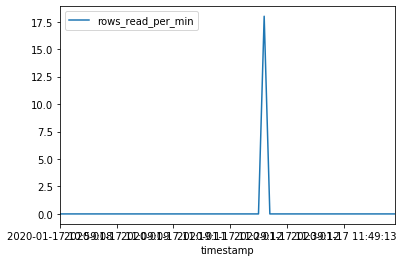

In [15]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
df.plot.line(x='timestamp',y='rows_read_per_min') 
plt.show()

### Storage Usage
You can access the storage report page directly by calling it into an IFrame or you can access the data from an API. In the report below you can select the timeframe for storage usage, group by table or schema, select the object you want to analyze and then select View Details from the Actions column.

In [16]:
IFrame(database+'/console/?mode=compact#monitor/storage'+profileURL, width=1400, height=480)

You can also list storage by schema. The following example retrieves the current level of storage usage. 

In [17]:
# List storage used by schema
# Display the top ten schemas
r = databaseAPI.getRequest('/metrics/storage/schemas?end=0&include_sys=true&limit=1000&offset=0&start=0') 

if (databaseAPI.getStatusCode(r)==200):
    json = databaseAPI.getJSON(r)        
    if json['count'] > 0: 
        df = pd.DataFrame(json_normalize(json['resources']))
        print(', '.join(list(df)))
        df['space_mb'] = df['data_physical_size_kb'].apply(lambda x: x / 1024)
        df = df.sort_values(by='data_physical_size_kb', ascending=False)    
        display(df[['tabschema','space_mb']].head(10))
    else: 
        print('No data returned') 
else:
    print("RC: "+str(databaseAPI.getStatusCode(r)))    

timestamp, tabschema, type, lastused, rowcompmode, data_logical_size_kb, index_logical_size_kb, long_logical_size_kb, lob_logical_size_kb, xml_logical_size_kb, column_organized_data_logical_size_kb, total_logical_size_kb, data_physical_size_kb, index_physical_size_kb, long_physical_size_kb, lob_physical_size_kb, xml_physical_size_kb, column_organized_data_physical_size_kb, total_physical_size_kb, estimated_reclaim_size_kb, est_adapt_svgs_kb, est_adapt_svgs_pct, est_static_svgs_kb, est_static_svgs_pct, est_reclaim_svgs_pct


,tabschema,space_mb
3,DB2INST1,122.00000
0,SYSIBM,15.59375
1,IBM_RTMON,10.00000
2,SYSTOOLS,6.18750


### Next Steps
You can find a copy of this notebook at https://github.com/Db2-DTE-POC/db2dmc. This github library includes several other notebooks that that cover more advanced examples of how to use Db2 and Jupyter together through open APIs. 

You can also access a free hands-on interactive lab that uses all of the notebooks at: https://www.ibm.com/demos/collection/IBM-Db2-Data-Management-Console/. After you sign up for the lab you will get access to a live cloud based system running Db2, the Db2 Console as well as extensive Jupyter Notebooks and Python to help you learn more. 

#### Credits: IBM 2019, Peter Kohlmann [kohlmann@ca.ibm.com]